# Feature Selection Tutorial

In [1]:
import matplotlib
import matplotlib.pyplot as plt 

import numpy as np

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LinearRegression, lasso_path, lasso_stability_path, lars_path

import warnings

from scipy import linalg

from sklearn.linear_model import (RandomizedLasso, lasso_stability_path,
                                  LassoLarsCV)
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.metrics import auc, precision_recall_curve, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.utils.extmath import pinvh
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVR

import pandas as pd
%matplotlib inline

## 1. Introduction to Feature Selection

Feature selection is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. It is used for three reasons:

* simplification of models to make them easier to interpret by researchers/users,
* shorter training times,
* enhanced generalization by reducing overfitting

The central premise when using a feature selection technique is that the data contains many features that are either redundant or irrelevant, and can thus be removed without incurring much loss of information.

There are three main categories of feature selection algorithms: wrappers, filters and embedded methods. [1] This tutorial will mainly focuses on one of the well-known embedded methods Lasso and its variants.


## 2. Introduction to Lasso

### 2.1 What's Lasso
Lasso is one of the embedded methods for feature selection. Embedded methods are a group of techniques which perform feature selection as part of the model construction process.

Lasso penalizes the regressin coefficients in a linear model with an L1 penalty. Lasso can shrinking many of coefficients to zero and leads to sparse results. From this point of view, any features which have non-zero regression coefficients are 'selected' by the Lasso.


The loss function of a linear model with L1 penalty will have the following form:

$\frac{1}{2} \sum_{n=1}^{N}\{t_n - w^T\phi(x_n)\}^2 + \frac{\alpha}{2} \sum_{j=1}^{M} |w_j|$

The first part is the square loss function. The second part is the L1 penalty $\frac{\alpha}{2} \sum_{j=1}^{M} |w_j|$, in which M is the total number of features, $w$ is the coefficient vector, $\alpha$ controls how much L1 penalty the contributes to the overall loss and how many features will be selected. L1 penalty can also be used to improve the generalization of the model because it penalty the model complexity by $\sum_{j=1}^{M} |w_j|$ in the loss function.

### 2.2 Why Lasso Can be Used for Feature Selection
Firstly, if all the features are in the same scale. The coefficients of a linear model can represents how important the corresponding feature is. 

In **Exp. 1**, I simulate a regression problem with three features (in the same scale). The regression target y is a linear combination of the features plus some guassion noise.

$y = 0 * x_0 + 1 * x_1 + 2 * x_2 + noise$ 

So from the setup of experiment 1, we can see that the importance of different features is

$x_2 > x_1 > x_0$

In [2]:
# set the random seed
rng = np.random.RandomState(0)

**Exp. 1**

In [3]:
# Exp 1
n_samples = 10000
n_features = 3
noise_level = 0.2

X = rng.rand(n_samples, n_features)
coef = np.zeros(n_features)
coef[0] = 0.0
coef[1] = 1.0
coef[2] = 2.0

y = np.dot(X, coef) + noise_level * rng.normal(size=n_samples)

lr = LinearRegression()
lr.fit(X, y)
print 'Exp. 1, coefficient of linear regression\n%s' % str(lr.coef_)

lr = Lasso(alpha=0.001)
lr.fit(X, y)
print 'Exp. 1, coefficient of lasso\n%s' % str(lr.coef_)

Exp. 1, coefficient of linear regression
[-0.01119616  0.99446444  1.99559463]
Exp. 1, coefficient of lasso
[-0.          0.98258754  1.98367942]


/Users/jinyi/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


As we can see from **Exp. 1**, we can easily find the feature importances from the coefficient of the trained model.
And an important characteristic of the L1 penalty is that it will leads to sparse models. Sparse models means the weight of unimportant/irrelevent features will shrink to 0. 

In **Exp. 1**, the first feature $x_0$ is actually have nothing to do with our target. Its coefficient in the linear regression model is a very small value (still have some small contribution to the target, not exactly irrelevant). However, Lasso will directly shrink its coefficient to 0, which indicates that it's actually an irrelevant feature.


Here is another example shows how lasso performs when there are lots of irrelevant features. 
**Exp. 2** is also a regression problem with 50 features. However only 5 of them are relevant to the target ($x_0 - x_4$).

**Exp. 2**

Some help functions:
* plot_sel_path: plot how will the coefficients for relevant and irrelevant features change with different $\alpha$ setting

In [4]:
def plot_sel_path(X, y, coef, method='Lasso'):
    """Plot feature selection result
    """
    if method == 'Lasso':
#         alpha_grid, _, scores_path = lars_path(X, y, method='lasso', eps=0.05)
        alpha_grid, scores_path, _ = lasso_path(X, y, eps=0.001)
    elif method == 'Stability':
        alpha_grid, scores_path = lasso_stability_path(X, y, scaling=0.3, eps=0.001)
        
    plt.figure()
    hg = plt.plot(alpha_grid[1:] , scores_path[coef != 0].T[1:], 'r')
    hb = plt.plot(alpha_grid[1:] , scores_path[coef == 0].T[1:], 'k')
    ymin, ymax = plt.ylim()
    plt.xlabel(r'$(\alpha / \alpha_{max})$')
    plt.ylabel('Score for each feature')
    plt.axis('tight')
    plt.legend((hg[0], hb[0]), ('relevant features', 'irrelevant features'),
               loc='best')

Exp. 2, coefficients setting for the relevant features
 [ 0.5754498   0.93597176  0.66245048  0.32697755  0.4974818 ]


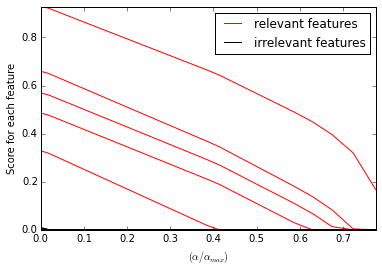

In [5]:
# Exp. 2
n_samples = 10000
n_features = 50
n_relevant_features = 5
noise_level = 0.2

X = rng.rand(n_samples, n_features)
coef = np.zeros(n_features)
coef[:n_relevant_features] = rng.rand(n_relevant_features)
y = np.dot(X, coef)
y += noise_level * rng.normal(size=n_samples)

print 'Exp. 2, coefficients setting for the relevant features\n %s' % str(coef[:n_relevant_features])
plot_sel_path(X, y, coef, "Lasso")

As we can see from the results, although lots of irrelevant features are given to the model. Lasso will shrink their coefficients to 0 very quickly.

### 2.4 Drawbacks of Lasso

There are some well-known limitations of Lasso, including
1. Lasso will tend to select an individual variable out of a group of highly correlated features,
2. even when the correlation between features is not too high, the conditions under which L1-penalized methods consistently select “good” features can be restrictive in general.


## 3. Variants of Lasso

There are lots of variants of Lasso that try to overcome some of the drawbacks.

One of the interesting work is Stability Selection. Sometimes, it's also called Randomized Lasso. It works by subsampling the training data and computing a Lasso estimate where the penalty of a random subset of coefficients has been scaled. Bolasso (Bootstrapped Lasso) is very similar, which using bootstraping to conduct random sampling.

By performing this double randomization several times, the method assigns high scores to features that are repeatedly selected across randomizations. In short, features selected more often are considered good features.


In **Exp. 3**, we generate some coherent features for a regression problem. Since there are some corelation between the features. Lasso will fail to select all relevant features.

**Exp. 3**

Some help function
* gen_simulation_dataset: generate some coherent random features for a regression problem

In [6]:
def gen_simulation_dataset(n_features=50, n_relevant_features=3, 
                           noise_level=0.2, coef_min=0.2, n_samples=10000,
                          rng=np.random.RandomState(0), conditioning=1):

    block_size = n_relevant_features

    # The coefficients of our model
    coef = np.zeros(n_features)
    coef[:n_relevant_features] = coef_min + rng.rand(n_relevant_features)

    # The correlation of our design: variables correlated by blocs of 3
    corr = np.zeros((n_features, n_features))
    for i in range(0, n_features, block_size):
        corr[i:i + block_size, i:i + block_size] = 1 - conditioning
    corr.flat[::n_features + 1] = 1
    corr = linalg.cholesky(corr)

    # 
    X = rng.normal(size=(n_samples, n_features))
    X = np.dot(X, corr)
    # Keep [Wainwright2006] (26c) constant
    X[:n_relevant_features] /= np.abs(
        linalg.svdvals(X[:n_relevant_features])).max()
    X = StandardScaler().fit_transform(X.copy())

    # The output variable
    y = np.dot(X, coef)
    y /= np.std(y)
    # We scale the added noise as a function of the average correlation
    # between the design and the output variable
    y += noise_level * rng.normal(size=n_samples)    
    
    return X, y, coef

Exp. 3, coefficients of the relevant features
[ 0.42871572  0.31671741  0.69989626]


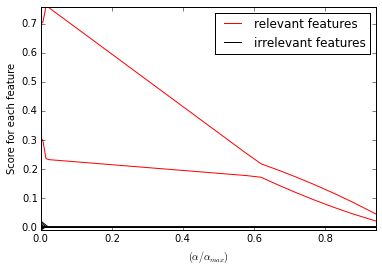

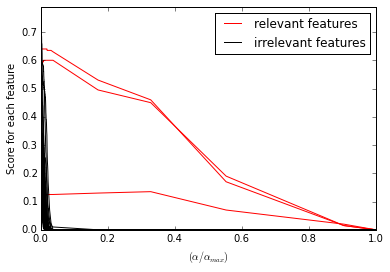

In [7]:
# Exp 3 
X, y, coef = gen_simulation_dataset(n_samples=500, rng=rng, conditioning=1e-4)
print 'Exp. 3, coefficients of the relevant features\n%s' % str(coef[coef!=0])

plot_sel_path(X, y, coef, 'Lasso')

plot_sel_path(X, y, coef, 'Stability')

As we can see from the results, Lasso will fail to select all the relevant features if there are some corelation between the features. However, Randomized Lasso or Stability Selection will overcome such drawback and select all relevant features.

## 4. Real Dataset

In this section, we will conduct some experiments to see how Lasso and Randomized Lasso performed on a real dataset. In **Exp. 4**, I am using the same dataset in the contest for assignment 4. So you can download the dataset from the course website [link](http://www.datasciencecourse.org/hw/4/data.tar.gz). I use the tiidf as the features and them conduct feature selection on top of it using Lasso.


**Exp. 4**

In [8]:
def read(idx):
    f_X = 'data/X'+str(idx)+'.txt'
    f_Y = 'data/Y'+str(idx)+'.txt'

    f = open(f_X, 'r')
    x = []
    for l in f:
        x.append(l)
    f.close()
    f = open(f_Y, 'r')
    y = []
    for l in f:
        y.append(int(l))
    f.close()
    return x, y

x_all = []
y_all = []
for i in range(1, 9):
    x, y = read(i)
    x_all.extend(x)
    y_all.extend(y)

x_true = []
x_false = []
for i in range(len(y_all)):
    if y_all[i] == 1:
        x_true.append(x_all[i])
    else:
        x_false.append(x_all[i])

In [9]:
print len(x_all), len(y_all), len(x_true), len(x_false)

80000 80000 36326 43674


After loading the whole dataset, we transfer it into tfidf matrix.

In [10]:
from natural_language_processing import tfidf
tfidf_all, words_all = tfidf(x_all)
print tfidf_all.shape

(80000, 1245607)


So there are about 1245607 features in total.

In [11]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

X = tfidf_all
y = y_all

lsvc = LinearSVC(C=0.02, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True, threshold='mean')
X_new = model.transform(X)
print X_new.shape

mask = model.get_support()
print 'Number of feature selected'
print np.sum(mask)

print 'After feature selection'
lsvc.fit(X_new, y)
y_pred = lsvc.predict(X_new)
print np.sum(y_pred != y) / float(len(y))

(80000, 1307)
Number of feature selected
1307
After feature selection
0.0002


As we can see from the results, although with the all 1245607 features, we may achieve 0 error rate on the training set. However, with the help of Lasso, we can select and use only 1307 features and still achieve a very low error rate. 

Follow up can be found at [link](https://github.com/JinyiLu/15-688-Tutorial/blob/master/Feature%20Selection%20Tutorial.ipynb)

## 5. References
1. Guyon, Isabelle, and André Elisseeff. "An introduction to variable and feature selection." Journal of machine learning research 3.Mar (2003): 1157-1182. [link](http://www.jmlr.org/papers/volume3/guyon03a/guyon03a.pdf)
* Feature selection - Wikipedia. [link](https://en.wikipedia.org/wiki/Feature_selection)

* Sklearn [link](http://scikit-learn.org/stable/modules/feature_selection.html#randomized-l1)
* F. Bach, Model-Consistent Sparse Estimation through the Bootstrap. [link]( https://hal.inria.fr/hal-00354771/)
* N. Meinshausen, P. Buhlmann, Stability selection, Journal of the Royal Statistical Society, 72 (2010)[link](http://arxiv.org/pdf/0809.2932.pdf)
* http://stats.stackexchange.com/questions/45643/why-l1-norm-for-sparse-models
* UCI Machine Learning Repository [link](http://archive.ics.uci.edu/ml/index.html)
* http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/
* http://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_recovery.html#sphx-glr-auto-examples-linear-model-plot-sparse-recovery-py
* http://statistics.berkeley.edu/sites/default/files/tech-reports/709.pdf
* https://en.wikipedia.org/wiki/Covariance